# Representing quantum computers for the transpiler

This page overviews how the constraints of a `backend` are represented and what the transpiler does with that information. In order to construct an optimized circuit that can run on a specific system, the transpiler needs certain details about the system.  This information is found in two places, the `backend` object you plan to submit jobs to, and the backend's `Target` attribute.

- The [`Target`](../api/qiskit/qiskit.transpiler.Target) contains all the relevant constraints of a device such as its native basis gates, qubit connectivity, and pulse or timing information.  
- The [`Backend`](../api/qiskit/qiskit.providers.BackendV2) typically possesses a `Target` by default and contains additional information such as the most recently calibrated error rates or the [`InstructionScheduleMap`](../api/qiskit/qiskit.pulse.InstructionScheduleMap).




The more information about these constraints a `Target` or `Backend` has, the more precisely the transpiler can produce the best circuit to run on that hardware.



<Admonition type="note">
Because many of the underlying transpilation algorithms are stochastic, there is no guarantee that a better circuit will be found.
</Admonition>

<span id="default-config"></span>
## Default configuration

The simplest use of the transpiler is to provide all the system information by providing the `backend` or `target`. To better understand how the transpiler works, construct a circuit and transpile it with different information:

Import the necessary libraries and instantiate the system or simulator:

In [1]:
from qiskit import transpile
from qiskit.circuit.library import EfficientSU2
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke

backend = FakeSherbrooke()
target = backend.target

The `EfficientSU2` circuit consists of layers of single-qubit operations spanned by `SU(2)` and `CX` entanglements. This is a heuristic pattern that can be used to prepare trial wave functions for variational quantum algorithms or classification circuits for machine learning.

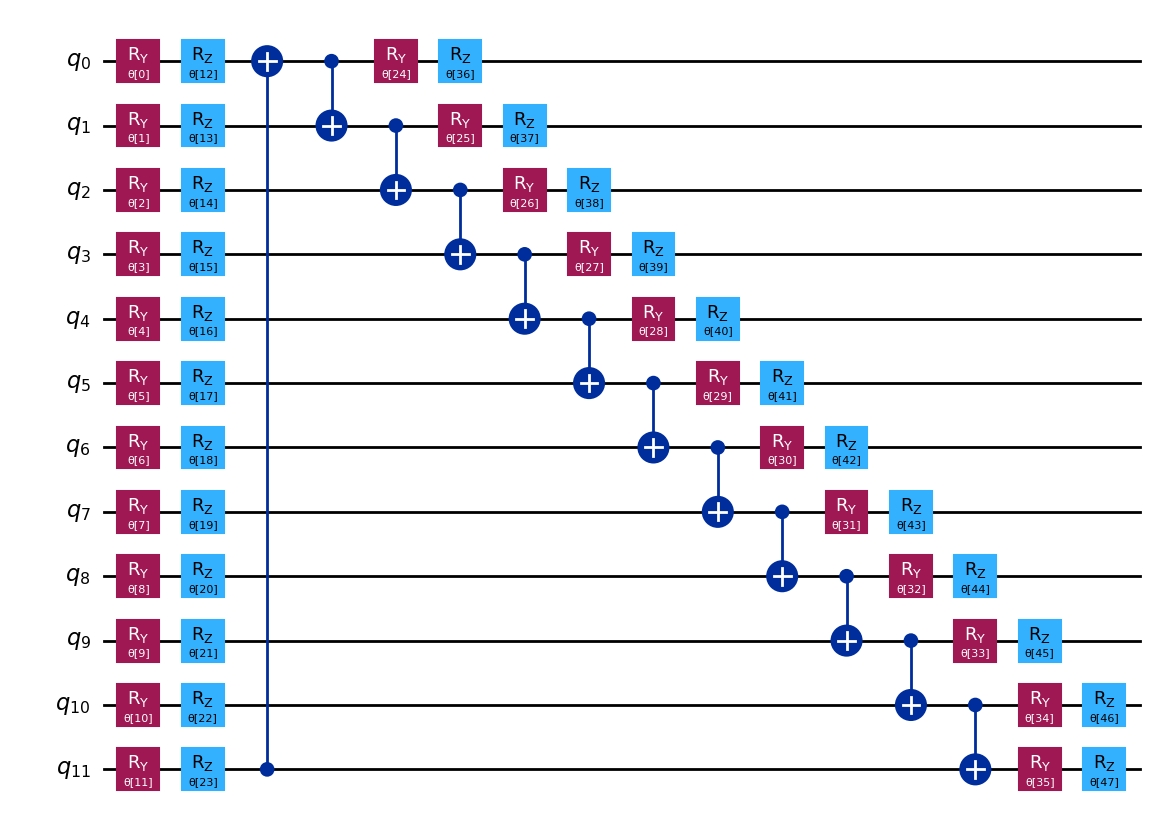

In [2]:
qc = EfficientSU2(12, entanglement="circular", reps=1)
qc.decompose(reps=1).draw("mpl", style="iqp")

### Transpile the circuit to `backend` target

This example uses the default `optimization_level=1` to transpile to the `backend`'s `target`, which providers all the information to the transpiler that is necessary to convert circuit to one that will run on the system.  (Note that if a `target` is specified in the `transpile` function, this will override the target from the `backend`.)

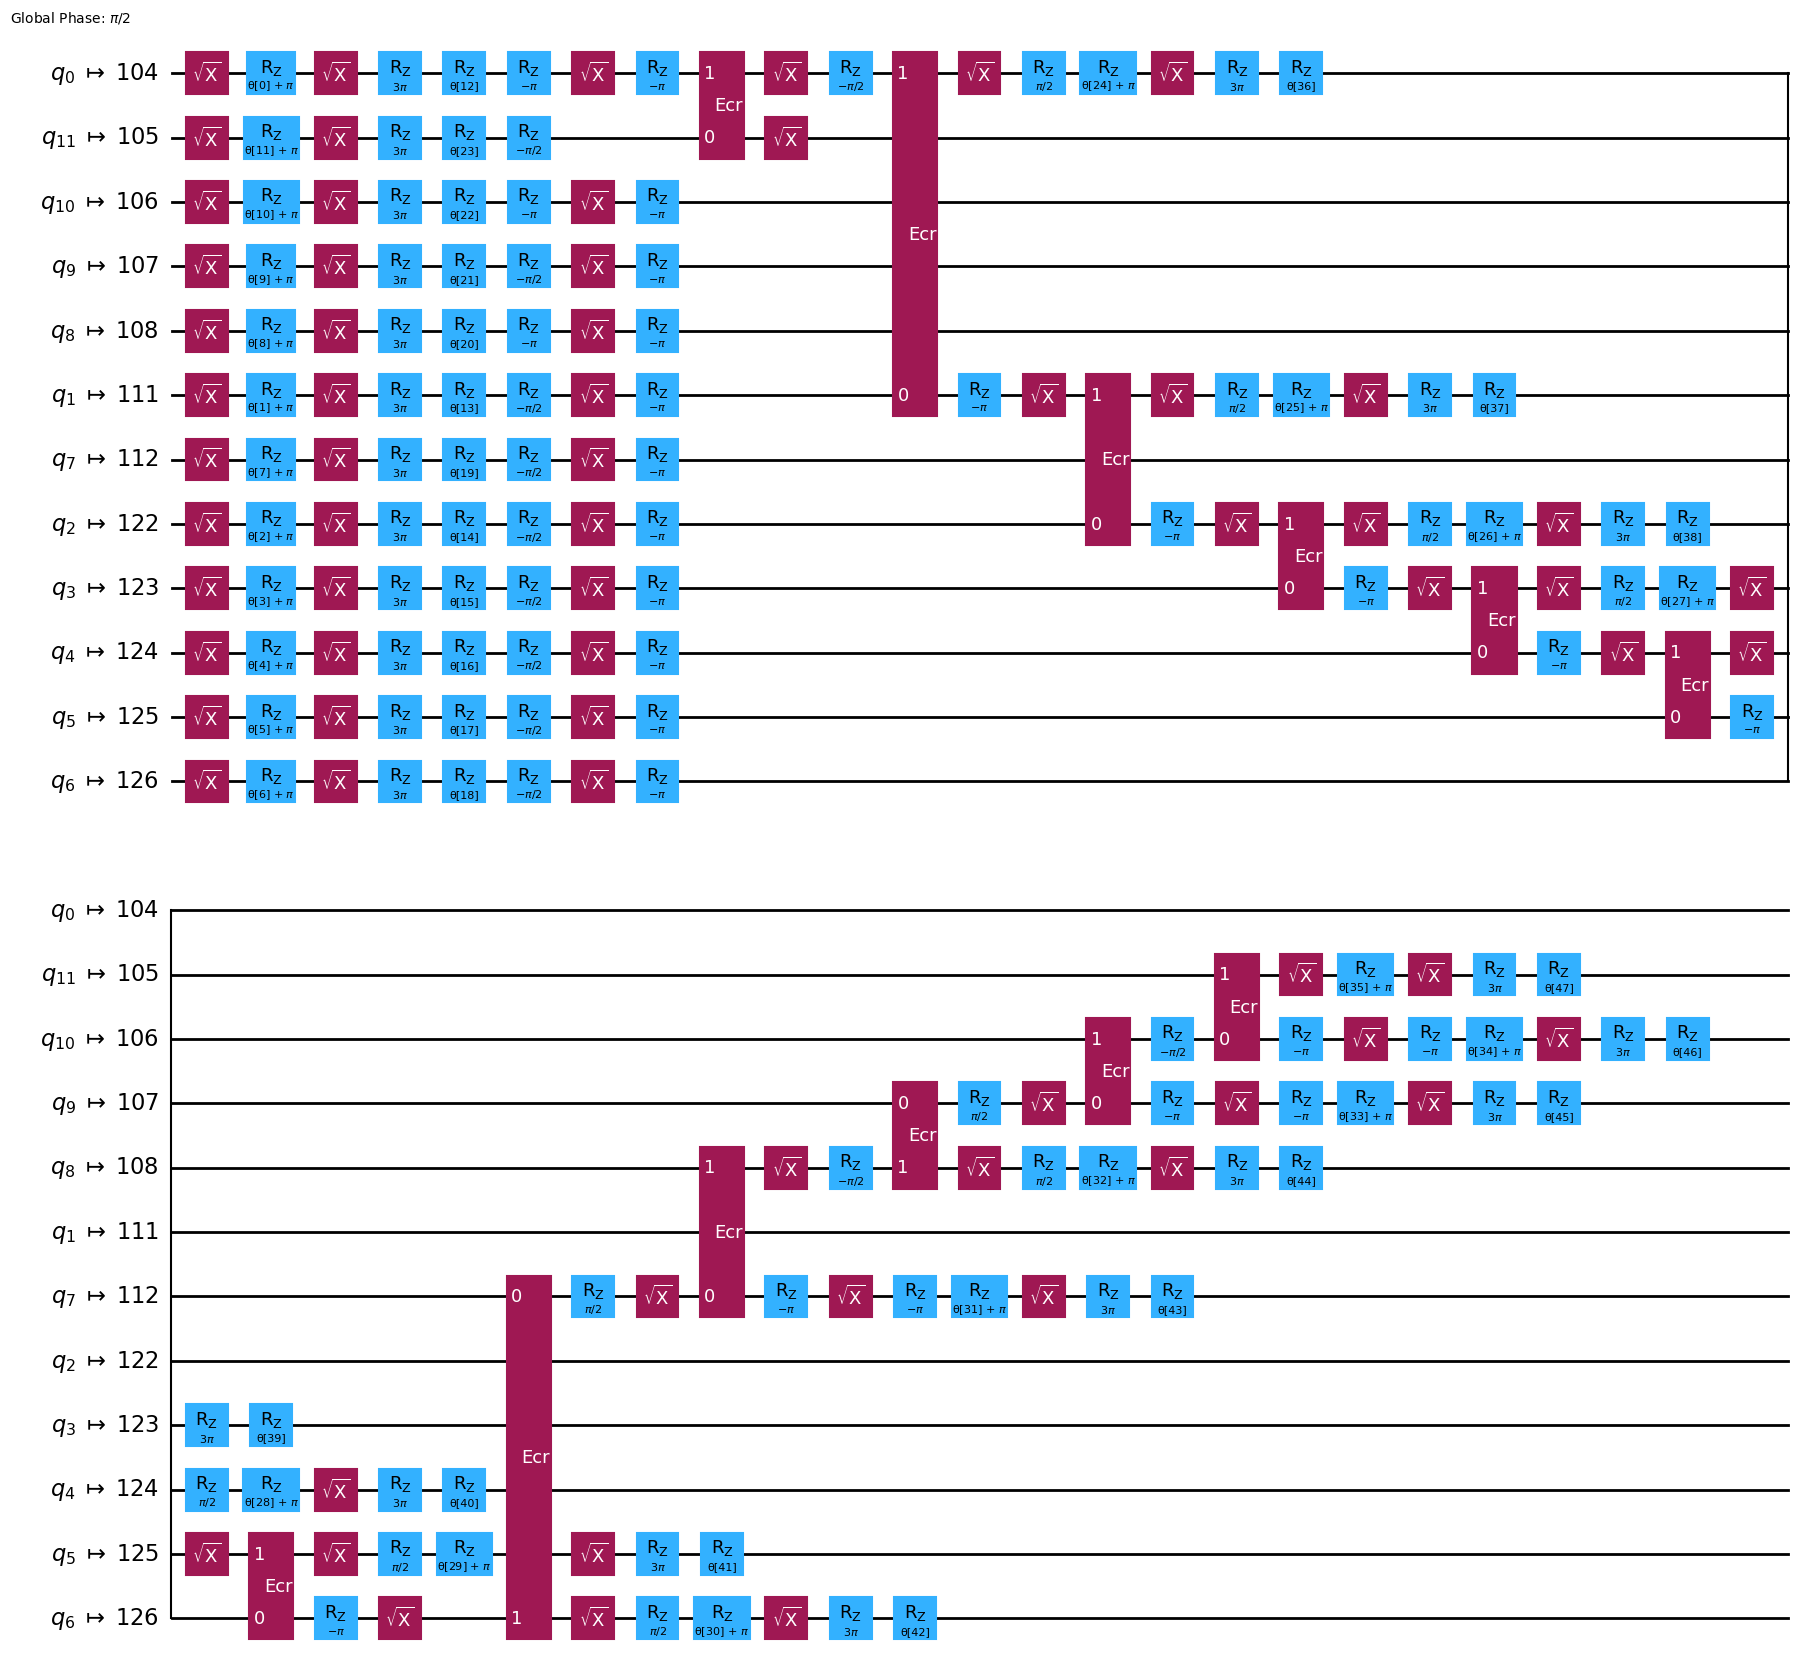

In [3]:
qc_t_target = transpile(qc, target=target, seed_transpiler=12345)
qc_t_target.draw("mpl", style="iqp", idle_wires=False)

This example is used in later sections of this topic to illustrate that the coupling map and basis gates are the essential pieces of information to pass to the transpiler for optimal circuit construction. The system can usually select default settings for other information that is not passed in, such as timing and scheduling.

Providing the `backend` properties, including the gates' error rates, allows the transpiler to select the best set of qubits on the system.


## Basis gates

Every quantum system supports a limited instruction set, called its _basis gates_.  Every gate in the circuit must be translated to the elements of this set. This set should consist of single- and two-qubit gates that provide a universal gates set, meaning that any quantum operation can be decomposed into those gates.  This is done by the [BasisTranslator](../api/qiskit/qiskit.transpiler.passes.BasisTranslator), and the basis gates can be specified as a keyword argument to the transpiler to provide this information.

In [ ]:
basis_gates = list(target.operation_names)
print(basis_gates)

['measure', 'x', 'ecr', 'delay', 'rz', 'sx']


The default single-qubit gates on _ibm_sherbrooke_ are `rz`, `x`, and `sx`, and the default two-qubit gate is `ecr` (echoed cross-resonance). CX gates are constructed from `ecr` gates, so on some systems `ecr` is specified as the two-qubit basis gate, while on others `cx` is the default. The `ecr` gate is the _entangling_ part of the `cx` gate. To use a gate that is not in the basis gate set, follow instructions in the Qiskit SDK API documentation for custom gates using [pulse gates](/api/qiskit/qiskit.transpiler.passes.PulseGates#pulsegates). In addition to the control gates, there are also `delay` and `measurement` instructions.

<Admonition>
    Systems have default basis gates, but you can choose whatever gates you want, as long as you provide the instruction or add pulse gates (see [Create transpiler passes.](custom-transpiler-pass)) The default basis gates are those that calibrations have been done for on the system, so no further instruction/pulse gates need to be provided. For example, on some systems `cx` is the default two-qubit gate and `ecr` on others. See the [Native gates and operations](../run/native-gates) topic for more details.
</Admonition>

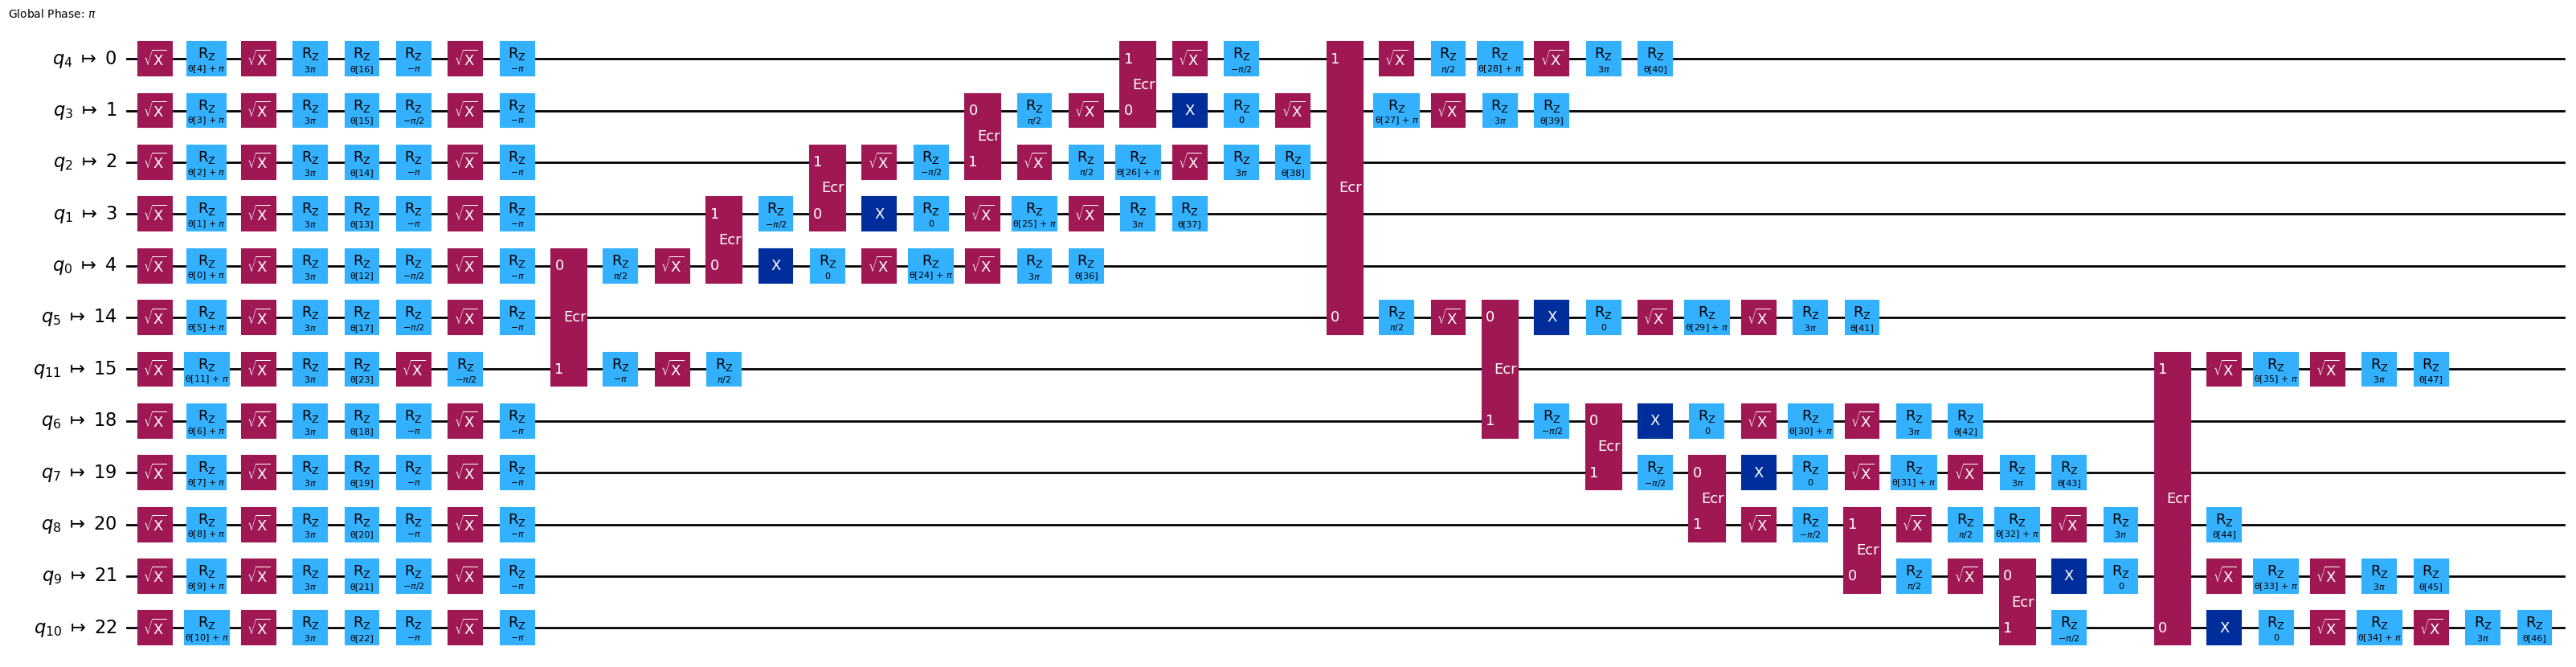

In [ ]:
qc_t_cm_bg = transpile(
    qc, coupling_map=coupling_map, basis_gates=basis_gates, seed_transpiler=11
)
qc_t_cm_bg.draw("mpl", style="iqp", fold=-1, idle_wires=False)

Note that the `CXGate`s have been decomposed to `ecr` gates and single-qubit basis gates.



## Coupling map

The coupling map is a graph that shows which qubits are connected and hence have two-qubit gates between them. Sometimes this graph is directional, meaning that the two-qubit gates can only go in one direction. However, the transpiler can always flip a gate's direction by adding additional single-qubit gates. An abstract quantum circuit can always be represented on this graph, even if its connectivity is limited, by introducing SWAP gates to move the quantum information around.

The qubits from our abstract circuits are called _virtual qubits_ and those on the coupling map are _physical qubits_. The transpiler provides a mapping between virtual and physical qubits. One of the first steps in transpilation, the _routing_ stage, performs this mapping.

<Admonition type="note">
Although the routing stage is intertwined with the _layout_ stage -- which selects the actual qubits -- by default, we will consider them as separate stages for simplicity. The combination of routing and layout is called _qubit mapping_.  Learn more about these stages in the [Transpiler stages](transpiler-stages) topic.
</Admonition>

Pass the `coupling_map` keyword argument to see its effect on the transpiler:

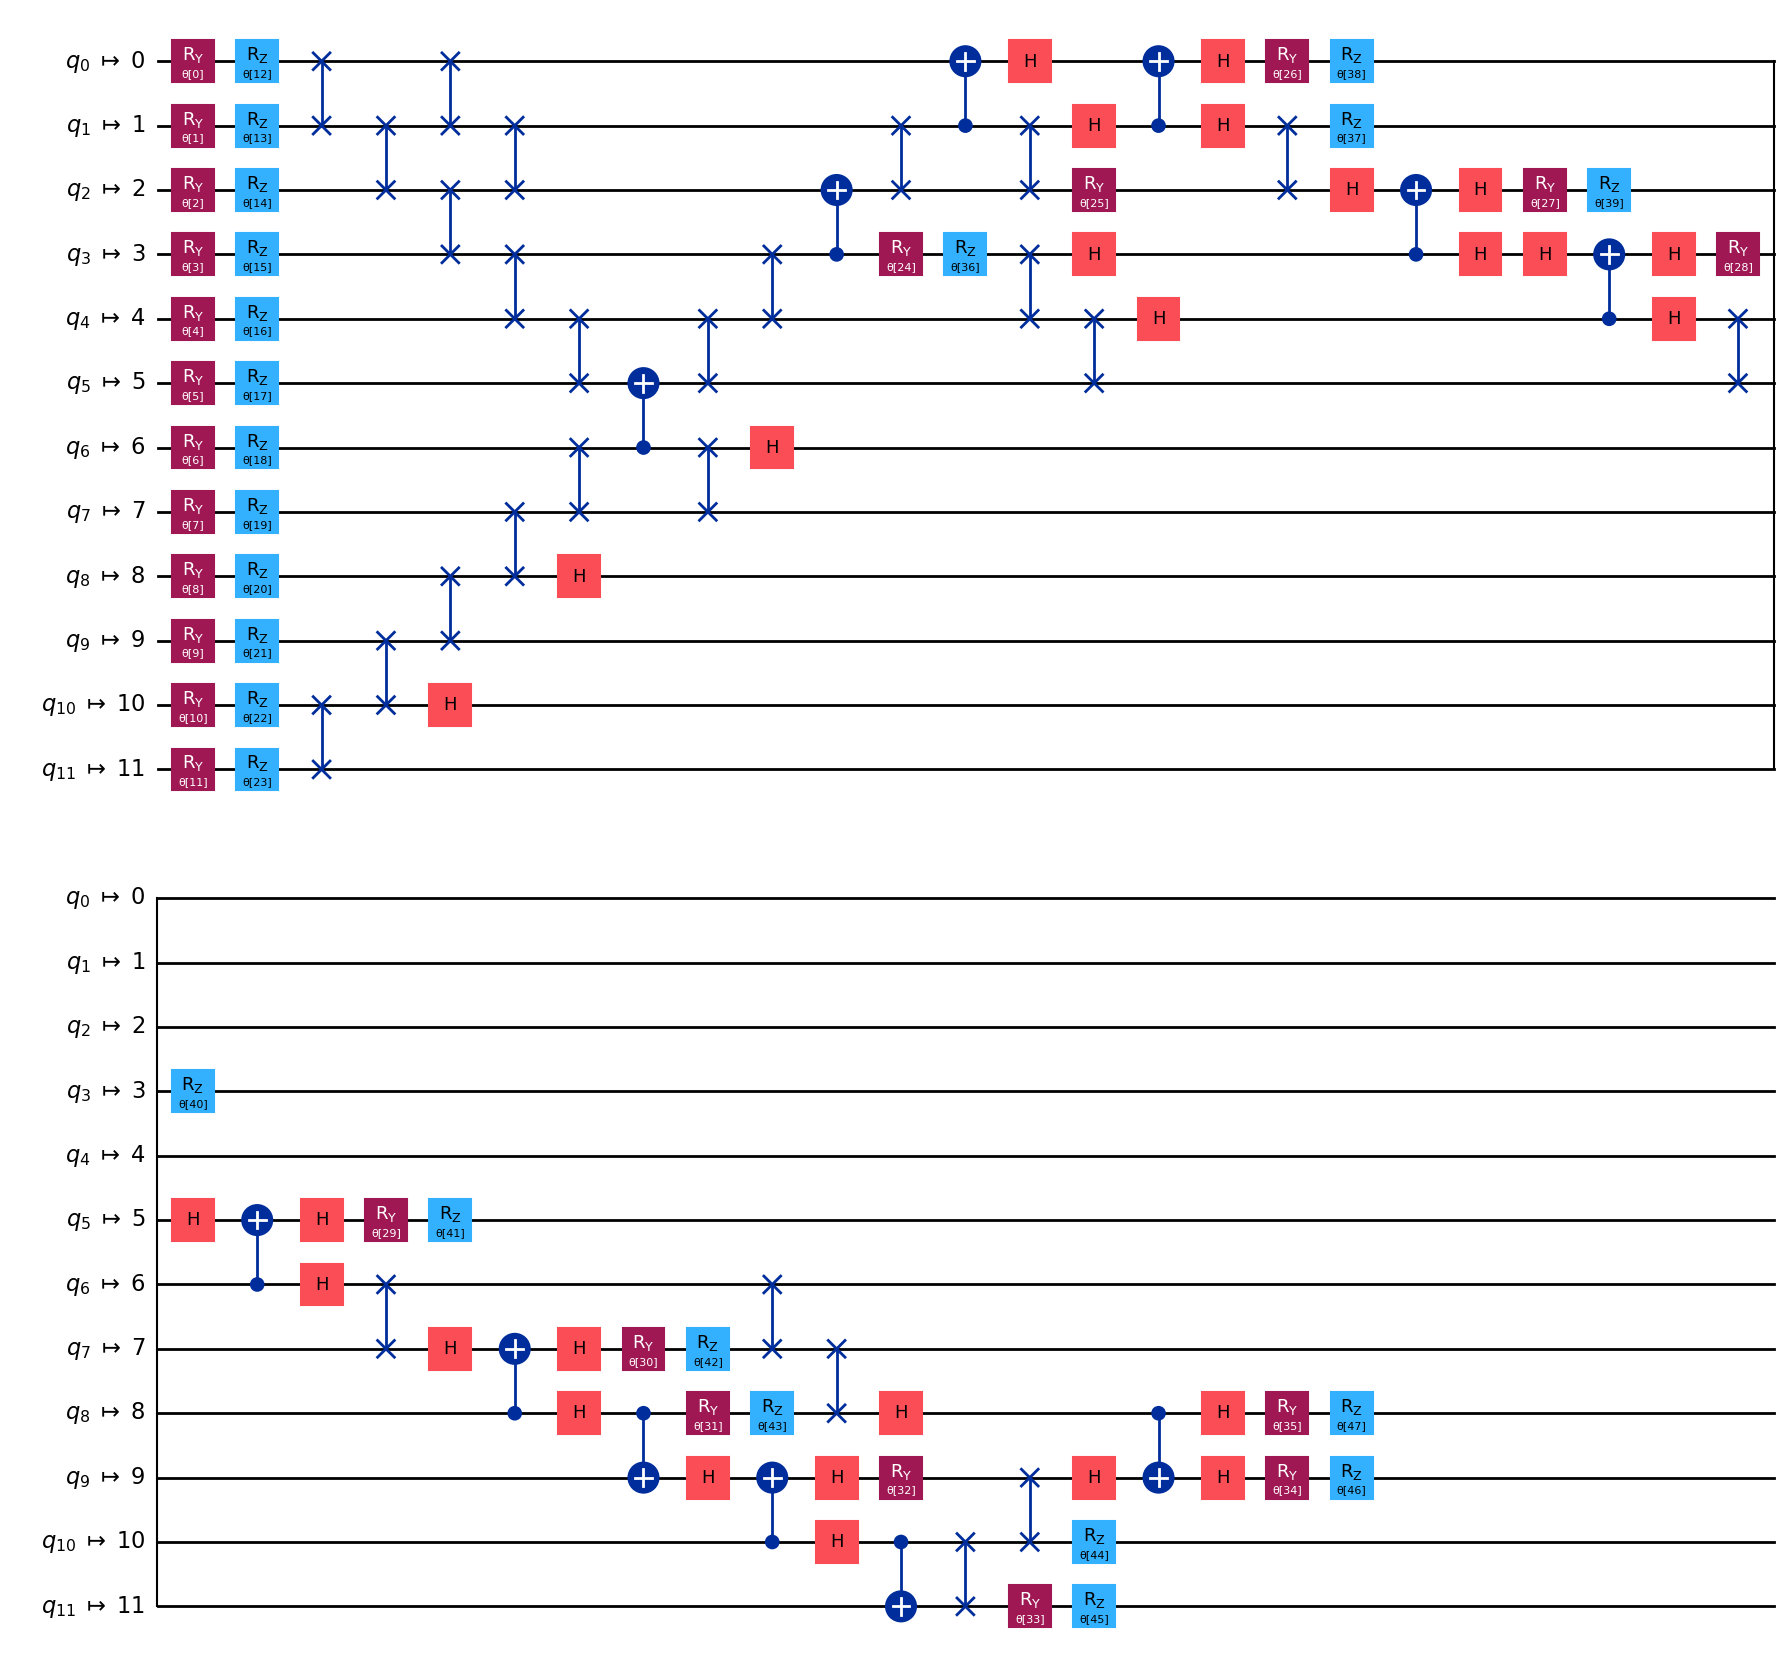

In [4]:
coupling_map = target.build_coupling_map()

qc_t_cm_lv0 = transpile(
    qc, coupling_map=coupling_map, optimization_level=0, seed_transpiler=11
)
qc_t_cm_lv0.draw("mpl", style="iqp", idle_wires=False)

As shown above, several SWAP gates were inserted (each consisting of three CX gates), which will cause a lot of errors on current devices. To see which qubits are selected on the actual qubit topology, use `plot_circuit_layout` from Qiskit Visualizations:

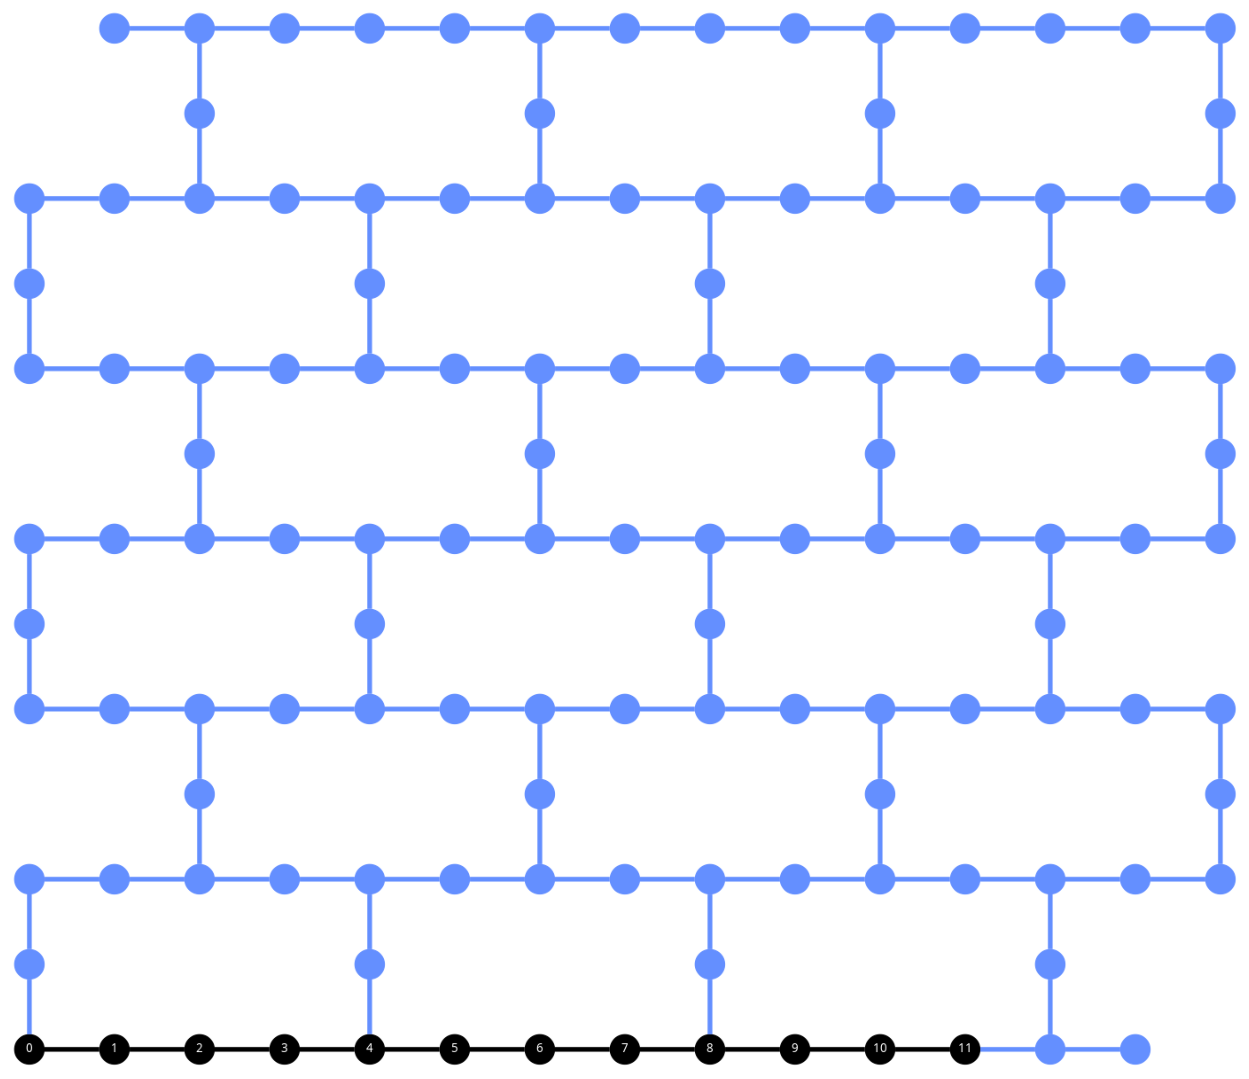

In [5]:
from qiskit.visualization import plot_circuit_layout

plot_circuit_layout(qc_t_cm_lv0, backend, view="physical")

This shows that our virtual qubits 0-11 were trivially mapped to the line of physical qubits 0-11. Let's return to the default (`optimization_level=1`), which uses `VF2Layout` if any routing is required.

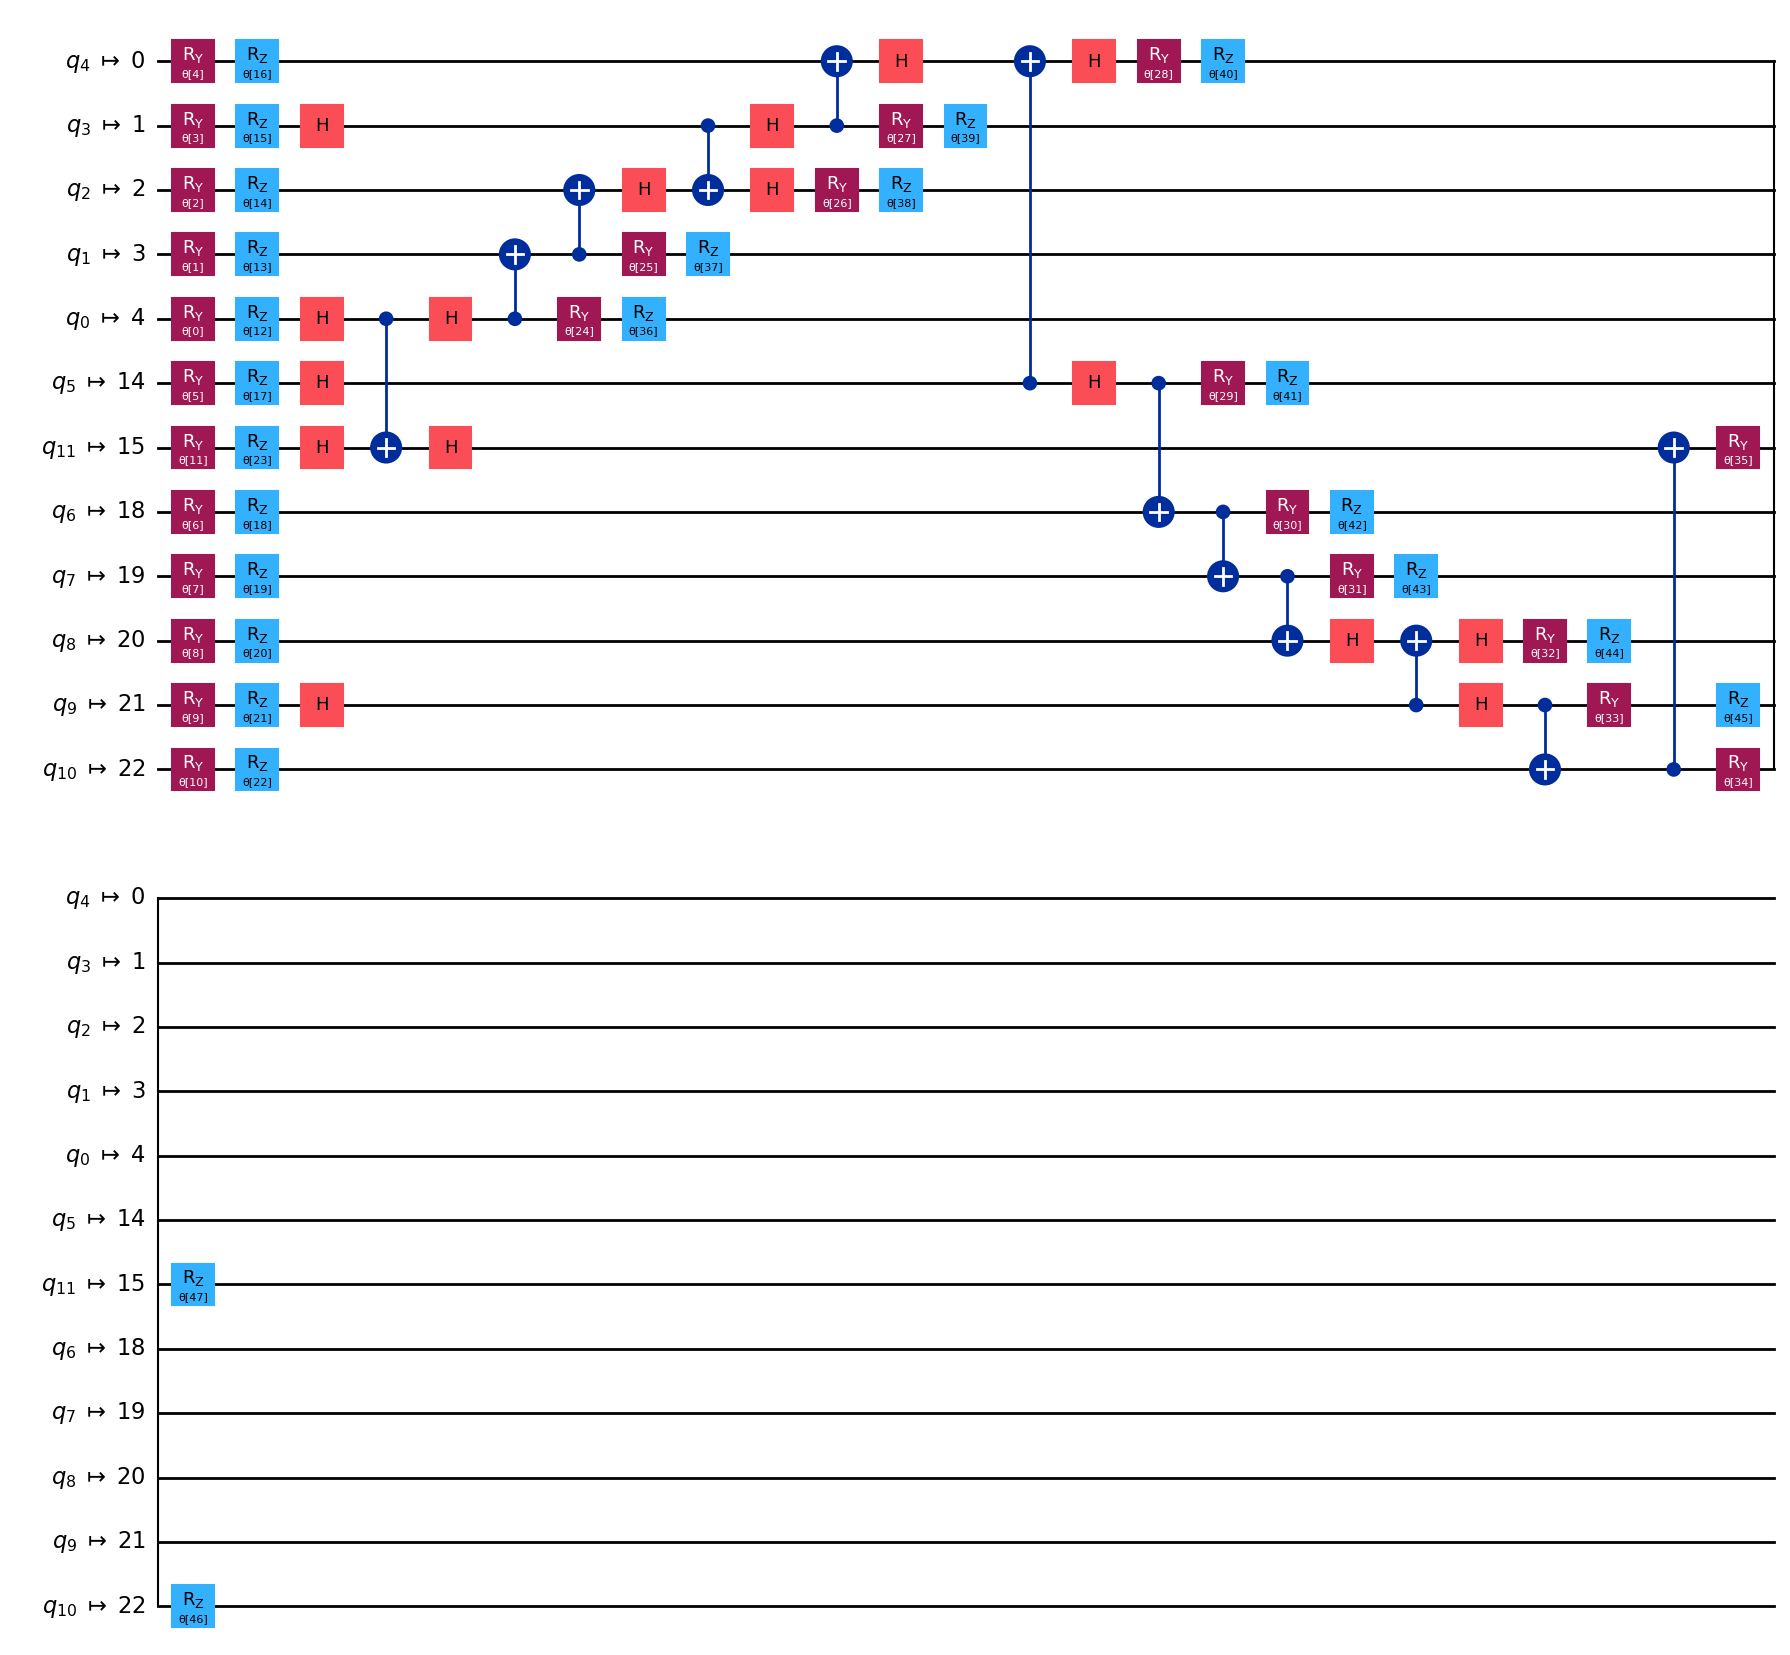

In [6]:
qc_t_cm_lv1 = transpile(qc, coupling_map=coupling_map, seed_transpiler=11)
qc_t_cm_lv1.draw("mpl", style="iqp", idle_wires=False)

Now there are no SWAP gates inserted and the physical qubits selected are the same when using the `target` class.

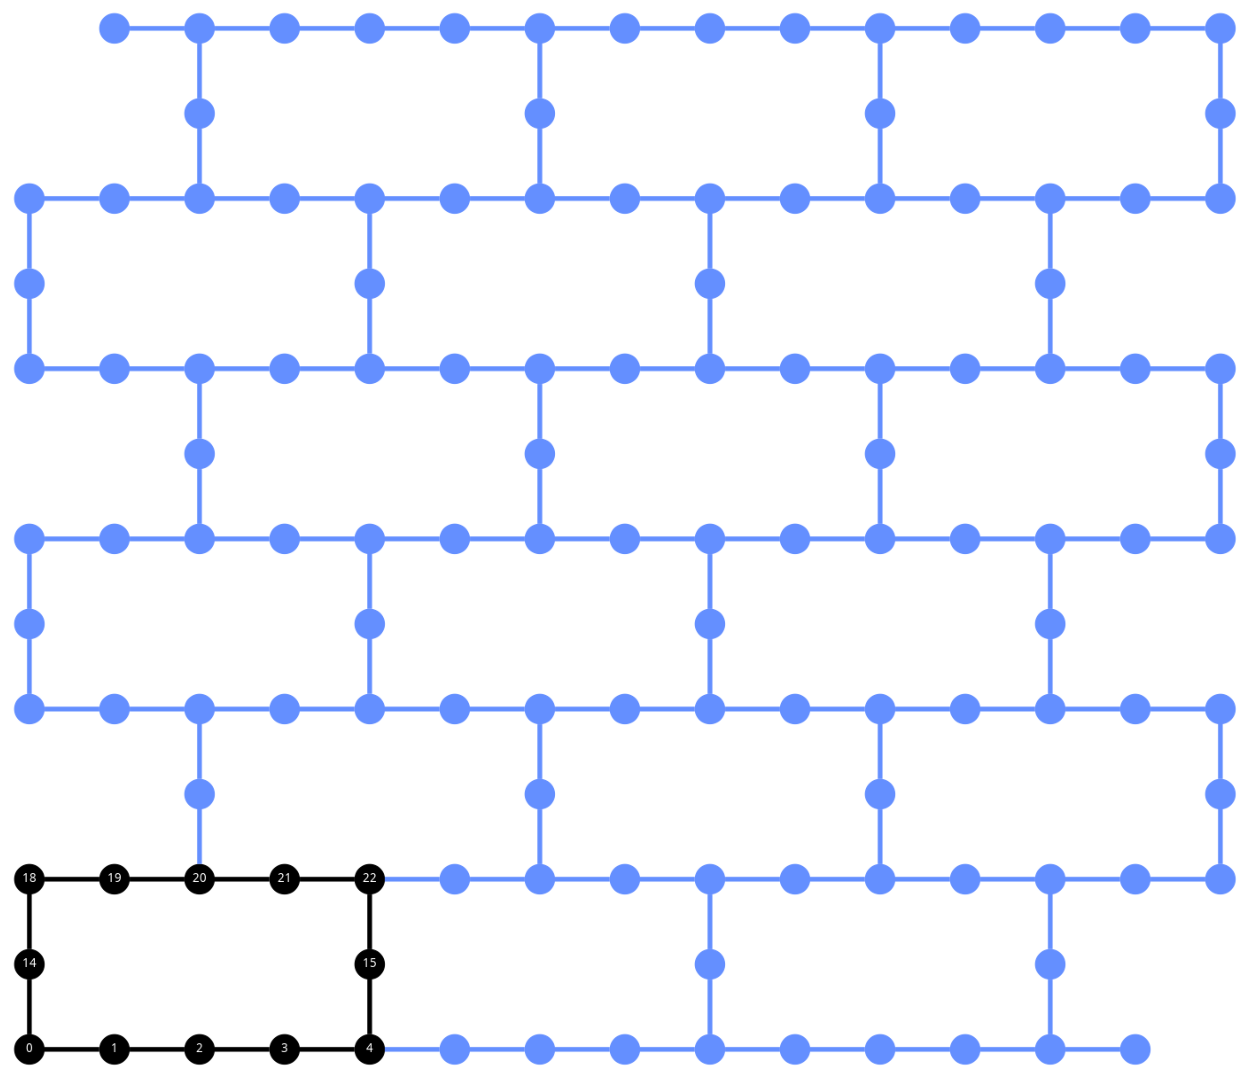

In [7]:
from qiskit.visualization import plot_circuit_layout

plot_circuit_layout(qc_t_cm_lv1, backend, view="physical")

Now the layout is in a ring.  Because this layout respects the circuit's connectivity, there are no SWAP gates, providing a much better circuit for execution.

## Next steps

<Admonition type="tip" title="Recommendations">
    - Understand [Transpilation default settings and configuration options.](defaults-and-configuration-options)
    - Review the [Commonly used parameters for transpilation](common-parameters) topic.
    - Try the [Submit transpiled circuits](https://learning.quantum.ibm.com/tutorial/submit-transpiled-circuits) tutorial.
    - See the [Transpile API documentation.](/api/qiskit/transpiler)
</Admonition>